In [1]:
from sklearn.cluster import KMeans
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


class TowerIDentificator():
    def __init__(self):
        self.BASE_STATIONS: dict = {
            1: {"radius": 1, "capacity": 2000, "cost": 50000},
            2: {"radius": 2, "capacity": 10000, "cost": 180000},
        }
        self.MAXIMIZE_PRECENT: float = 95.0
        self.MAX_AMOUNT_STATIONS: int = 150
        self.kmeans = KMeans(n_clusters=self.MAX_AMOUNT_STATIONS, init='k-means++', tol=1e-3, max_iter=300, random_state=42)
        self.data = None

    def apply_kmeans(self):
        """
        Кластеризация домов с использованием KMeans.
        """
        self.data['cluster'] = self.kmeans.fit_predict(self.data[['latitude', 'longitude']])
        return self.data, self.kmeans.cluster_centers_

    def assign_stations(self, cluster_centers):
        """
        Назначение базовых станций с учетом ограничений.
        """
        stations = []
        total_coverage: set = set()
        
        for i, center in enumerate(cluster_centers):
            cluster_houses = self.data[self.data['cluster'] == i]
            total_devices = cluster_houses['end_devices_count'].sum()

            station_type = 1 if total_devices <= self.BASE_STATIONS[1]['capacity'] else 2
            station_radius = self.BASE_STATIONS[station_type]['radius']

            selected_house = None
            for _, house in cluster_houses.iterrows():
                house_coords = (house['latitude'], house['longitude'])
                center_coords = (center[0], center[1])
                if geodesic(house_coords, center_coords).km <= station_radius:
                    selected_house = house
                    break
                
            cluster_coverage = self.calculate_coverage(self.data, [center], self.BASE_STATIONS[station_type]['radius'])
            total_coverage.update(cluster_coverage)
            
            print(f"[{i}/{len(cluster_centers)-1}] Create Stations.")
            if selected_house is not None:
                stations.append({
                    "house_uuid": selected_house['house_uuid'],
                    "type": station_type,
                })
        return stations, total_coverage
    
    def calculate_coverage(self, houses, centers, radius):
        covered_houses = set()
        for center in centers:
            for _, house in houses.iterrows():
                if geodesic(center, house['coordinates']).km <= radius:
                    covered_houses.add(house['house_uuid'])
        return covered_houses

    def start(self, path_input_data = "house.csv"):
        data_file = path_input_data
        self.data = pd.read_csv(data_file, delimiter=';')
        self.data['coordinates'] = self.data[['latitude', 'longitude']].apply(tuple, axis=1)

        data, cluster_centers = self.apply_kmeans()

        stations, total_coverage = self.assign_stations(cluster_centers)

        output_data = pd.DataFrame(stations)
        output_data.to_csv("output_stations.csv", sep=';', index=False)
        self.draw_stations(data, stations)
        print(f"[{len(total_coverage)/len(data['house_uuid'])*100}%] Coverage.")
        print("[+] Результаты сохранены в output_stations.csv")

    def draw_stations(self, data, stations):
        houses_file = "house.csv" 
        houses = pd.read_csv(houses_file, delimiter=';')
        
        plt.figure(figsize=(10, 10))
       
        
        for station in stations:
            house_uuid = station['house_uuid']
            station_type = station['type']
            house_data = data[data['house_uuid'] == house_uuid]
            plt.scatter(
                house_data['longitude'],
                house_data['latitude'],
                color='red' if station_type == 1 else 'blue',
                marker='^',  
                s=100, 
                label=f'Station Type {station_type}',
            )
        plt.scatter(houses['longitude'], houses['latitude'], c='black', s=10, label='Дома')

        plt.title("Расположение домов и базовых станций")
        plt.xlabel("Долгота")
        plt.ylabel("Широта")
        #plt.legend()
        plt.grid(True)
        plt.show()

[0/149] Create Stations.
[1/149] Create Stations.
[2/149] Create Stations.
[3/149] Create Stations.
[4/149] Create Stations.
[5/149] Create Stations.
[6/149] Create Stations.
[7/149] Create Stations.
[8/149] Create Stations.
[9/149] Create Stations.
[10/149] Create Stations.
[11/149] Create Stations.
[12/149] Create Stations.
[13/149] Create Stations.
[14/149] Create Stations.
[15/149] Create Stations.
[16/149] Create Stations.
[17/149] Create Stations.
[18/149] Create Stations.
[19/149] Create Stations.
[20/149] Create Stations.
[21/149] Create Stations.
[22/149] Create Stations.
[23/149] Create Stations.
[24/149] Create Stations.
[25/149] Create Stations.
[26/149] Create Stations.
[27/149] Create Stations.
[28/149] Create Stations.
[29/149] Create Stations.
[30/149] Create Stations.
[31/149] Create Stations.
[32/149] Create Stations.
[33/149] Create Stations.
[34/149] Create Stations.
[35/149] Create Stations.
[36/149] Create Stations.
[37/149] Create Stations.
[38/149] Create Statio

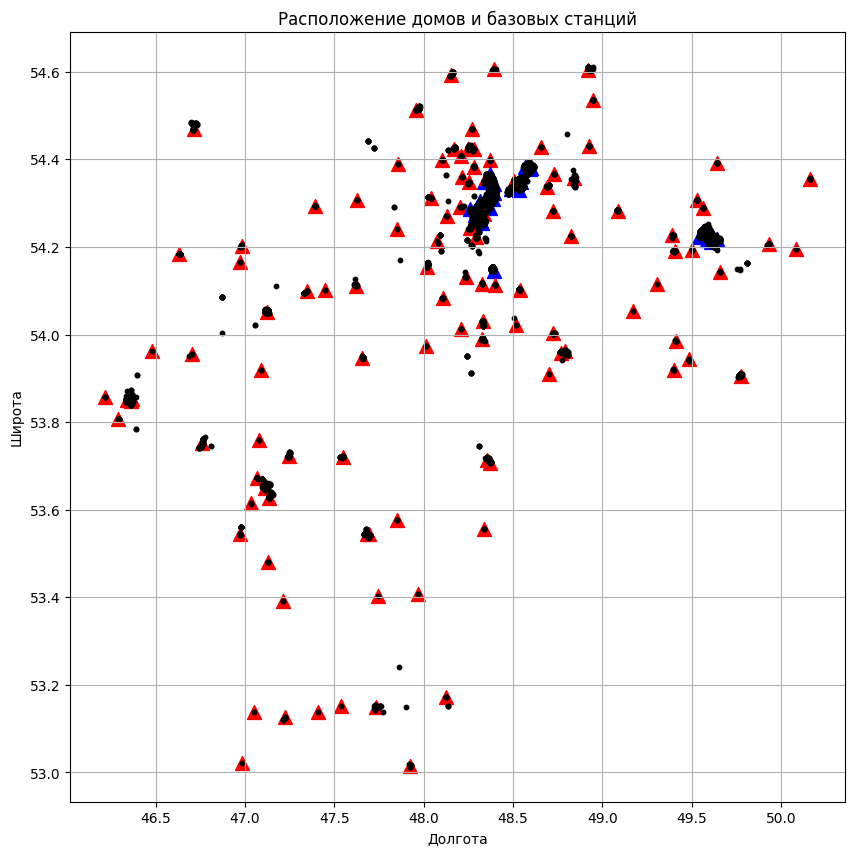

[96.33362293657689%] Coverage.
[+] Результаты сохранены в output_stations.csv


In [2]:
if __name__ == "__main__":
    tower_identifier = TowerIDentificator()  # Создаем экземпляр класса
    tower_identifier.start()